In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
from scipy.interpolate import interp1d
from scipy.integrate import quad
import random

In [3]:
from surp.analysis.vice_model import vice_model
from surp.analysis import apogee_analysis as aah
import seaborn as sns
import arya
import surp

from statsmodels.distributions import ECDF


In [4]:
fiducial = vice_model("../out/C11_f0.2_rand_walk.json")

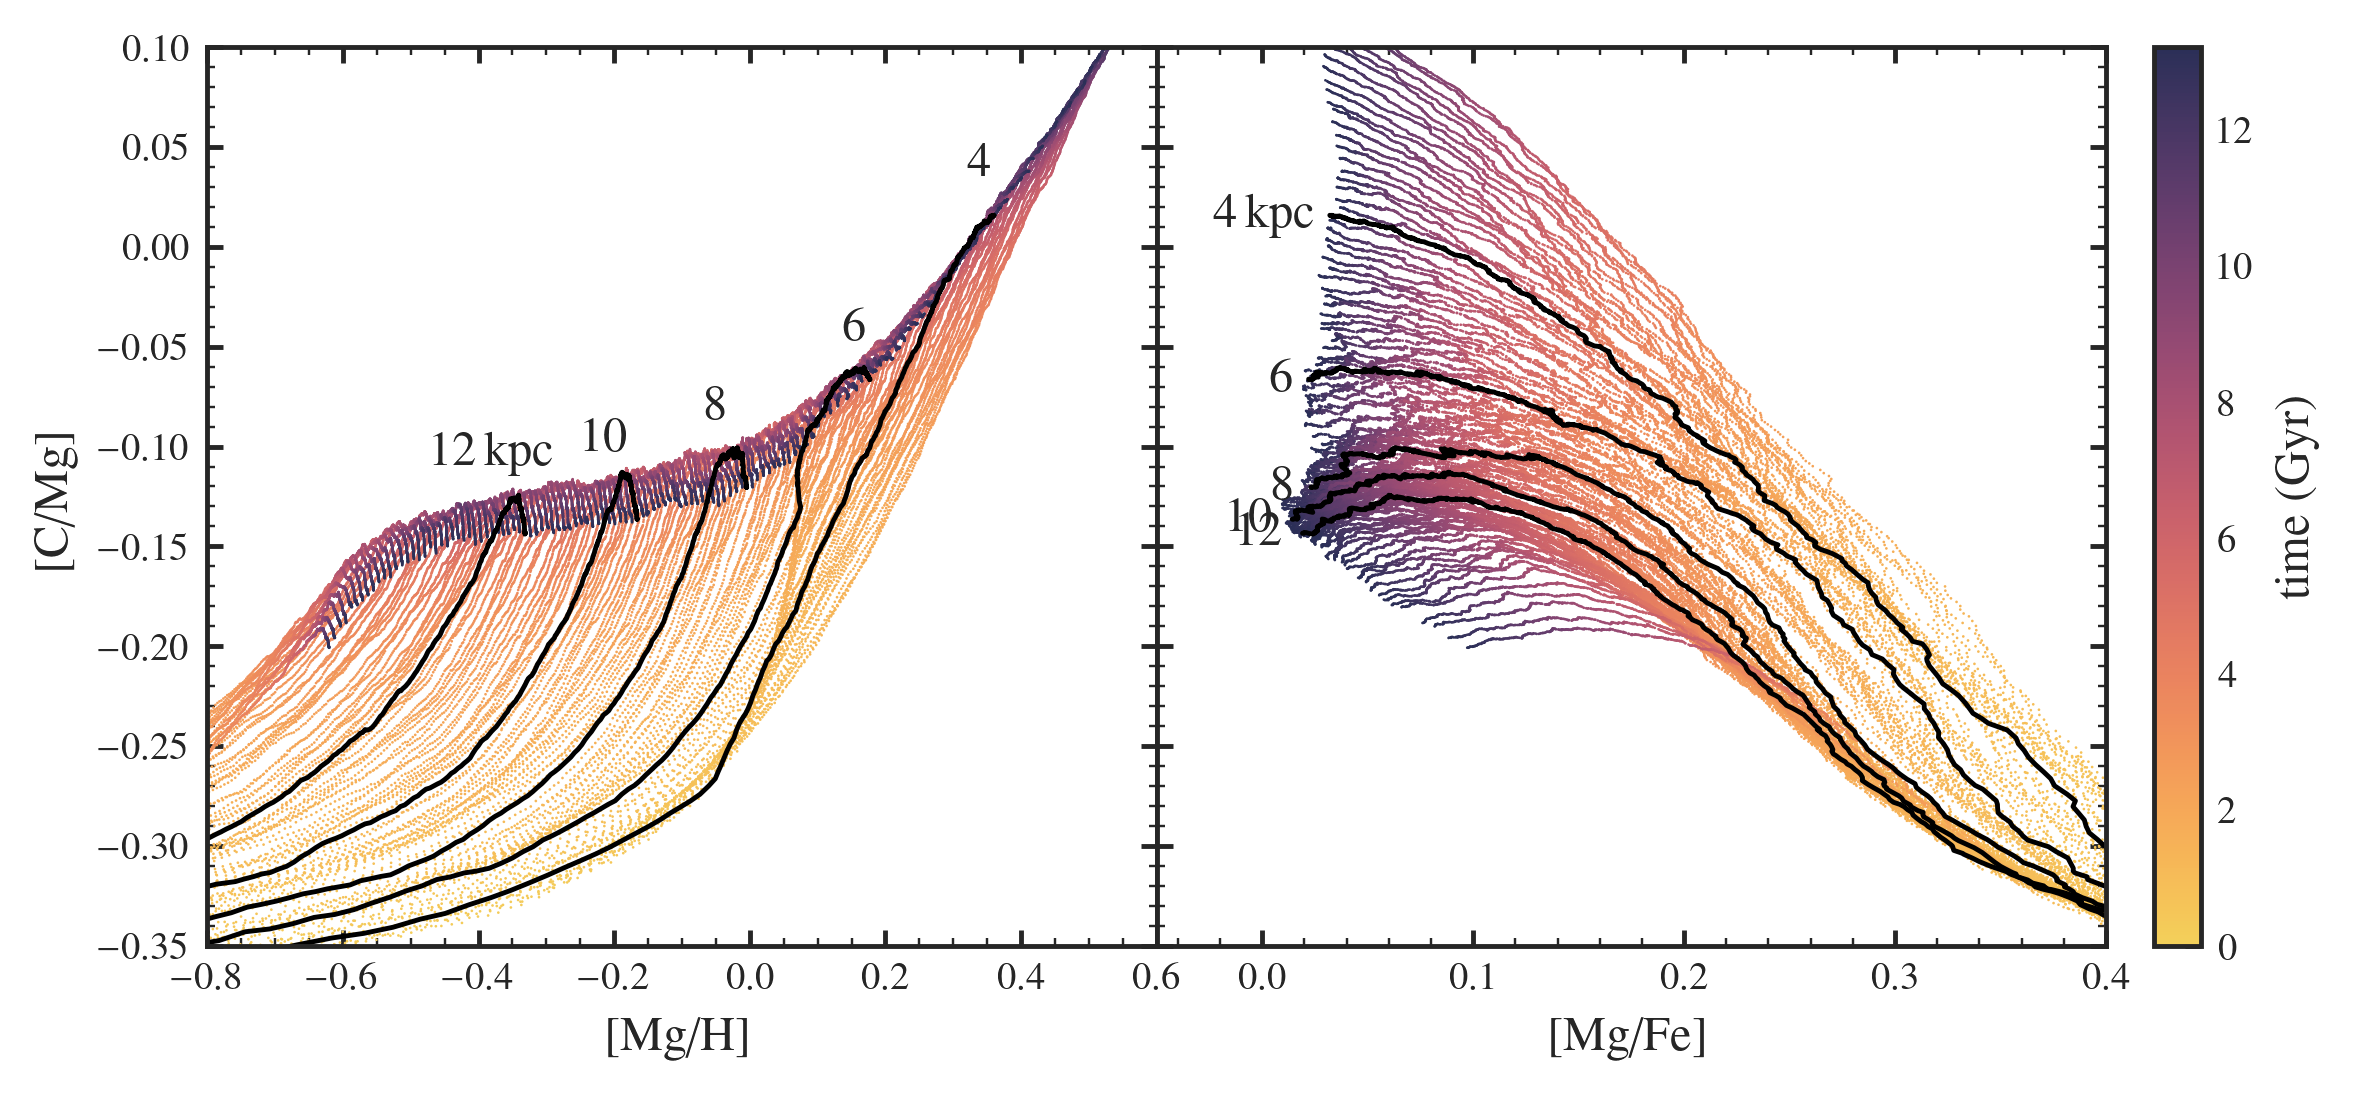

In [5]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3), dpi=350)

plt.sca(axs[0])
h = fiducial.history

coords = []

for R in [4, 6, 8, 10, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df["[o/h]"], df["[c/o]"], color="k")
    coords.append((
            df["[o/h]"][-1], 
            df["[c/o]"][-1]
        ))


texts = [
    "4",
    "6",
    "8",
    "10",
    r"12\,kpc"
]

for i in range(len(coords)):
    if i >= 2:
        offset = (-6, 12)
    else:
        offset = (-3, 6)
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="center", va="bottom",  
                        xycoords='data', textcoords='offset points', xytext=offset)

sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="[o/h]", y="[c/o]", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-0.8, 0.6)
plt.ylim(-0.4, 0.05)


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.sca(axs[1])



filt = fiducial.history["[o/h]"] > -0.15
filt &= fiducial.history["[o/h]"] < -0.05
h = fiducial.history

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

cb = arya.Colorbar(clim=(0, 13.2), label=r"time (Gyr)", cmap="arya_r", cax=cax)

coords = []

for R in np.sort(h.R.unique()[19:155]):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], c=cb(dfa.time), s=0.3, ec="none", rasterized=True, zorder=1)
    if any(np.isclose(R+0.05, [4, 6, 8, 10, 12])):
        coords.append((
            dfa["[o/fe]"][-1], 
            dfa["[c/o]"][-1]
        ))

        plt.plot(dfa["[o/fe]"], dfa["[c/o]"], color="k", zorder=2, lw=1)
    

texts = [
    "4\\,kpc",
    "6",
    "8",
    "10",
    r"12"
]

for i in range(len(coords)):
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="right",  va="center",
                        xycoords='data', textcoords='offset points', xytext=(-3, 0))
#     text.set_path_effects([mpl.patheffects.Stroke(linewidth=5, foreground='w'),
#                    mpl.patheffects.Normal()])
    
plt.xlim(-0.05, 0.4)
plt.ylim(-0.35, 0.1)
plt.xlabel("[Mg/Fe]")



plt.savefig("all_the_tracks.pdf")

# F AGB
Here, I want to make plots of the AGB Fraction across the galaxy.

In [14]:
def y_cc(Z):
    return surp.yields.C_CC_model(zeta=0.09, y0=0.004)(Z)

In [15]:
pwd

'/users/PAS2232/aeyobd/surp/carbon_paper'

In [19]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Zc = h["z(c)"]
Mc = h["mass(c)"] # Msun
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

In [20]:
max(f_agb[f_agb < 0.5])

0.4080823815774903

(-1.0, 1.0)

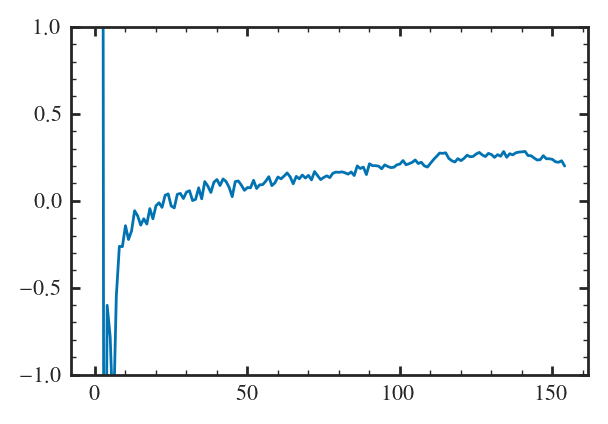

In [21]:
plt.plot(np.transpose(X)[-1,:])
plt.ylim(-1, 1)

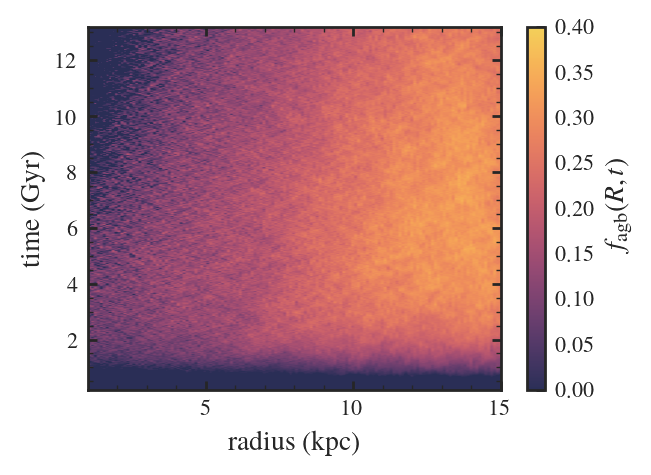

In [22]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.4), extent=(0, 20, 0, 13.2), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t)$")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

# Finding the peculiar zone -v-

In [ ]:
h1 = h[(h.R > 9.8) & (h.R < 10.2)]

In [ ]:
h2 = h[h.R == 10.05]

In [ ]:
h1.columns

In [ ]:
s = fiducial.stars_unsampled

s1 = s[s.zone_final==100]
s2 = s[(s.zone_final > 90) & (s.zone_final < 110)]

In [ ]:
for x in s.columns:

    
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    plt.sca(axs[0])
    
    plt.scatter(s2["age"], s2[x], s=0.3, color=(0.3, 0.3, 0.3))
    plt.scatter(s1["age"], s1[x], color="orange", s=0.3)
    plt.xlim(0, 13.5)
    plt.ylabel(x)
    plt.xlabel("age")

    plt.sca(axs[1])
    plt.scatter(s2["mass"], s2[x], s=0.3, color=(0.3, 0.3, 0.3))
    plt.scatter(s1["mass"], s1[x], color="orange", s=0.3)
    plt.xlim(0, 0.8e6)
    plt.ylabel(x)
    plt.xlabel("mass")
    
    plt.show()

In [ ]:
for x in h1.columns:
    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    plt.sca(axs[0])
    plt.scatter(h1["[c/o]"], h1[x], s=1, color=(0.5, 0.5, 0.5))
    plt.plot(h2["[c/o]"], h2[x])
    plt.xlim(-0.5, 0.2)
    
    plt.ylabel(x)
    plt.xlabel("[C/O]")

    plt.sca(axs[1])
    plt.scatter(h1["time"], h1[x], s=1, color=(0.5, 0.5, 0.5))
    plt.plot(h2["time"], h2[x])
    plt.xlim(0, 13.2)
    
    plt.ylabel(x)
    plt.xlabel("time")
    plt.show()

Text(0.5, 0, '[Mg/Fe]')

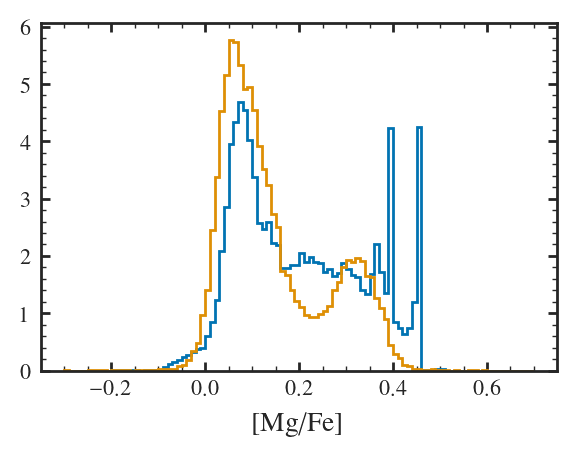

In [5]:
df = fiducial.history

plt.hist(df["[o/fe]"], 100, histtype="step", density=True, range=(-0.3, 0.7))
plt.hist(aah.subgiants["MG_FE"], 100, histtype="step", density=True, range=(-0.3, 0.7));
plt.xlabel("[Mg/Fe]")

In [32]:
df = fiducial.stars_unsampled

num = 10_000
idx = random.choices(np.arange(len(df)), weights=df["mass"], k=num)

result = {key: np.zeros(num) for key in df.keys()}


for i in range(num):
    for key in df.keys():
        result[key][i] = df[key][idx[i]]
        
result = pd.DataFrame(result)

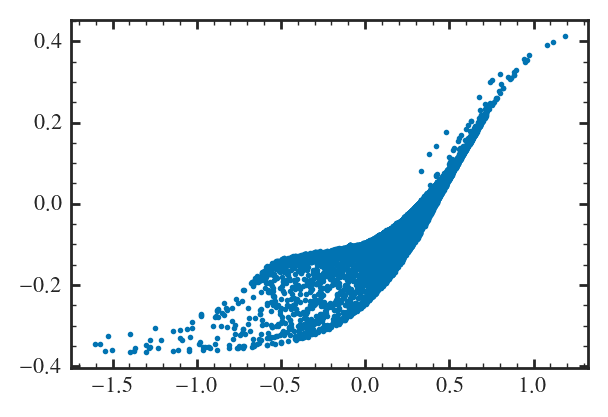

In [21]:
plt.scatter(result["[o/h]"], result["[c/o]"], s=1)

In [37]:
data = pd.read_csv("../data/apogee_cartography.csv", index_col=0)

/tmp/slurmtmp.23835997/ipykernel_223725/3603862041.py:1: DtypeWarning: Columns (126) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/apogee_cartography.csv", index_col=0)


In [38]:
data["MG_H"] = data["MG_FE"] + data["FE_H"]
data["C_H"] = data["C_FE"] + data["FE_H"]
data["N_H"] = data["N_FE"] + data["FE_H"]

data["CN_H"] = np.log10(10**(data["C_H"] + 8.39) + 10**(data["N_H"] + 7.78)) - np.log10(10**8.39 + 10**7.78)
data["CN_MG"] = data["CN_H"] - data["MG_H"]

data["high_alpha"] = aah.mg_fe_cutoff(data["FE_H"]) < data["MG_FE"]

df = data[~data["high_alpha"]]

In [35]:
result["[c/h]"] = result["[c/o]"] + result["[o/h]"]
result["[n/h]"] = result["[n/o]"] + result["[o/h]"]

result["[cn/h]"] = np.log10(10**(result["[c/h]"] + 8.39) + 10**(result["[n/h]"] + 7.78)) - np.log10(10**8.39 + 10**7.78)
result["[cn/o]"] = result["[cn/h]"] - result["[o/h]"] + 0.075

In [ ]:
arya.plotting.medianplot(result, x="[o/h]", y="[cn/o]",stat="median", aes="line", binsize=100, errorbar=None, label="model")


arya.plotting.medianplot(df, x="MG_H", y="CN_MG", binsize=200, stat="median", label="APOGEE Giants")
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.xlim(-0.65, 0.4)
plt.ylim(-0.2, 0.15)

arya.Legend(color_only=True)
plt.savefig("cpn.pdf")



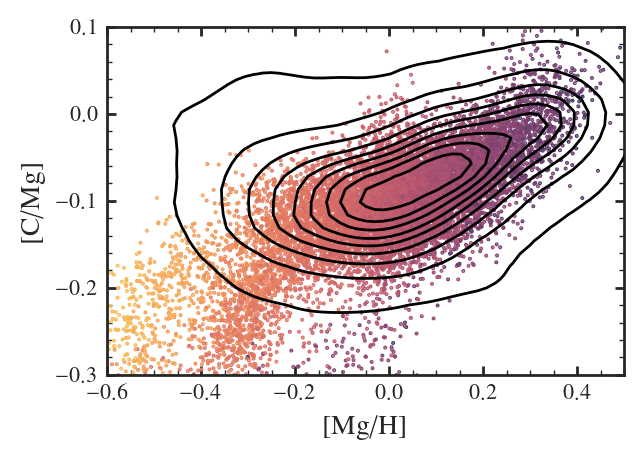

In [6]:
s = fiducial.stars
N = len(s)
dx = 0.03
dy = 0.03
aah.plot_contour("[mg/h]", "[c/mg]", zorder=3)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[c/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.3, 0.1)
plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.savefig("fiducial_scatter.pdf")

<Axes: xlabel='time', ylabel='sfr'>

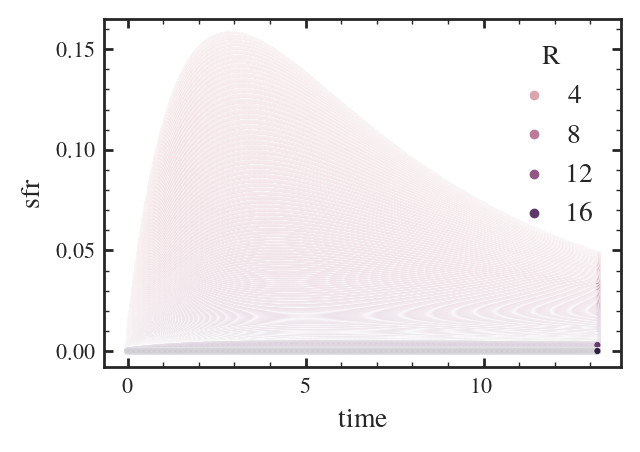

In [7]:
sns.scatterplot(fiducial.history, x="time", y="sfr", hue="R")

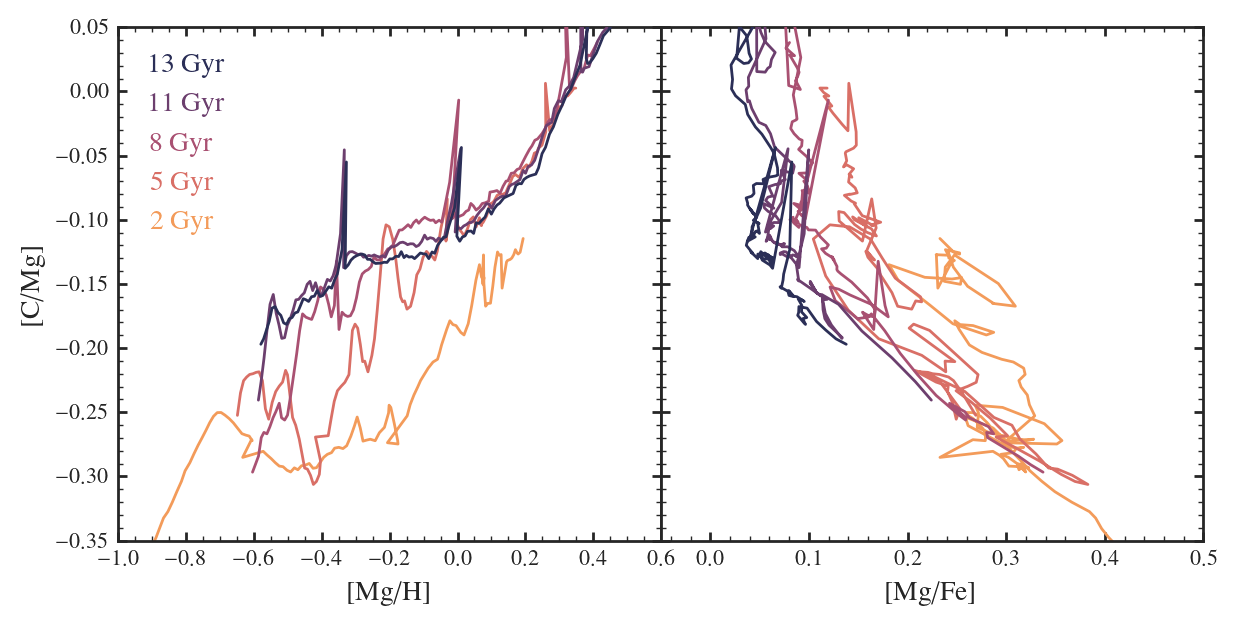

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_t_slices("[mg/h]", "[c/mg]")




plt.xlabel(r"[Mg/H]")
plt.ylim(-0.35, 0.05)
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)

plt.sca(axs[1])


fiducial.plot_t_slices("[mg/fe]", "[c/mg]",legend=False)



plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(-0.05, 0.5)

plt.savefig("evo_slices.pdf")

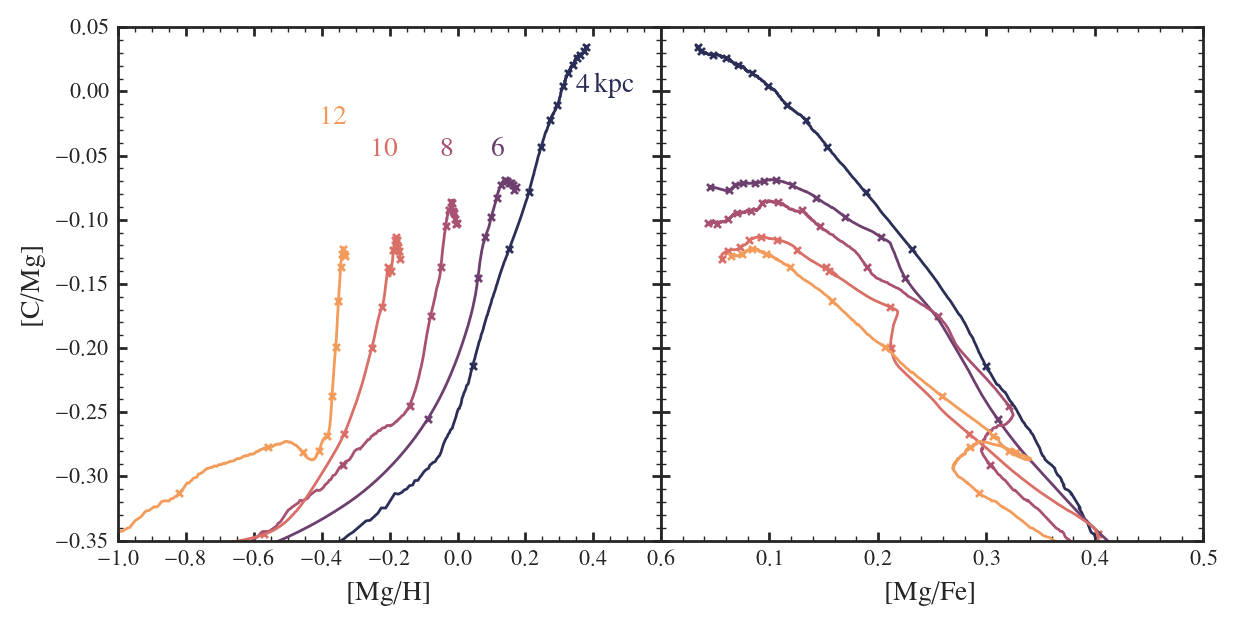

In [8]:

fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3))

plt.sca(axs[0])
fiducial.plot_R_slices("[mg/h]", "[c/mg]", legend=False)

colors = plt.get_cmap()(np.linspace(0.8, 0, 5))

coords = [
    (-0.4, -0.025),
    (-0.25, -0.05),
    (-0.05, -0.05),
    (0.1, -0.05),
    (0.35, 0.0)
]

texts = [
    "12",
    "10",
    "8",
    "6",
    r"4\,kpc"
]
for i in range(5):
    plt.text(*coords[i], texts[i], color=colors[i])

plt.xlabel(r"[Mg/H]")
plt.ylabel(r"[C/Mg]")
plt.xlim(-1, 0.6)
plt.ylim(-0.35, 0.05)


plt.sca(axs[1])
fiducial.plot_R_slices("[mg/fe]", "[c/mg]", legend=False)

plt.xlabel(r"[Mg/Fe]")
plt.ylabel("")
plt.xlim(0, 0.5)
plt.ylim(-0.35, 0.05)
plt.xticks(np.arange(0.1, 0.6, 0.1))

plt.savefig("evo_tracks.pdf")

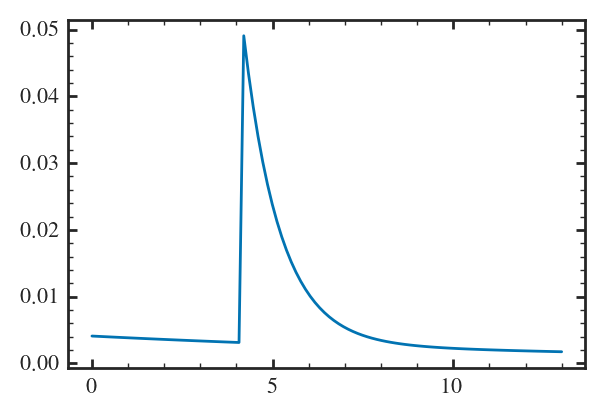

In [8]:
f = surp.simulation.star_formation_history.star_formation_history("twoexp")
R = 8
Ts = np.linspace(0, 13, 100)

plt.plot(Ts, [f(R, t) for t in Ts])

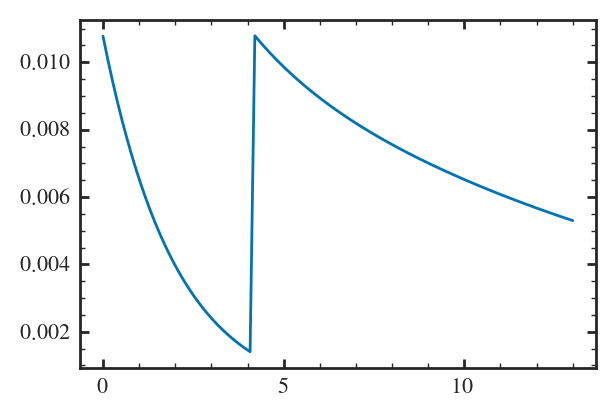

In [25]:
f = surp.simulation.star_formation_history.star_formation_history("twoinfall")
R = 8
Ts = np.linspace(0, 13, 100)

plt.plot(Ts, [f(R, t) for t in Ts])

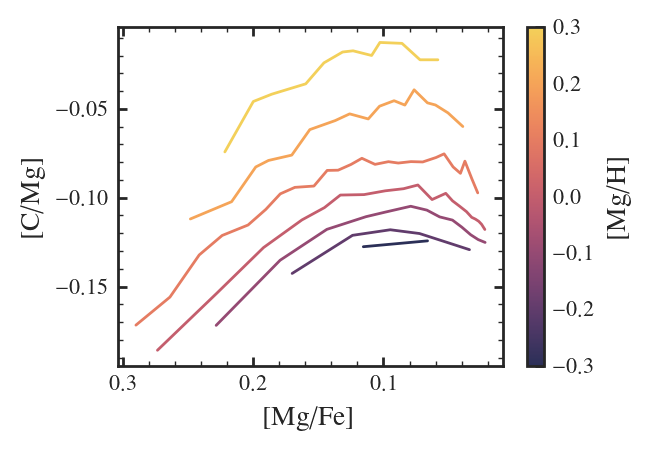

In [10]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    mh0 = MH - 0.05
    mh1 = MH + 0.05
    filt = s["[o/h]"] > mh0
    filt &= s["[o/h]"] < mh1
    df = s[filt]
    
    arya.medianplot(df, x="[o/fe]", y="[c/o]", binsize=100, color=cb(MH), aes="line", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")